### Exploring the annotated data.

In [1]:
from datasets import load_dataset, disable_caching
import pandas as pd
import os
from tqdm.auto import tqdm

# can infer the generic loader script this easily
disable_caching()
# cache location [click](%userprofile%/.cache/huggingface/datasets)
# needs force_redownload to avoid loading incorrect cached stuff
shader20k_files = os.listdir("./data/annotated")
# print(shader20k_files)
shader20k_files = [f"./data/annotated/{f}" for f in shader20k_files if f.startswith("20k")]
# ds = load_dataset("json", data_dir="./data/annotated", download_mode="force_redownload", cache_dir=None)
ds = load_dataset("json", data_files=shader20k_files, download_mode="force_redownload", cache_dir=None)
# ds = load_dataset("json", data_dir="./data/annotated_test/", download_mode="force_redownload", cache_dir=None)
df = ds["train"].to_pandas()
# read "date" column as unix timestamp
df["date"] = pd.to_datetime(df["date"].astype(int), unit="s")
ds

Resolving data files:   0%|          | 0/95 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/7939 [00:00<?, ? examples/s]

DatasetGenerationCastError: An error occurred while generating the dataset

All the data files must have the same columns, but at some point there are 30 new columns ({'image_code', 'image_inputs', 'buffer_b_code', 'cube_a_inputs', 'author', 'license', 'date', 'buffer_d_code', 'buffer_d_inputs', 'sound_code', 'published', 'likes', 'buffer_a_code', 'buffer_a_inputs', 'buffer_b_inputs', 'tags', 'thumbnail', 'functions', 'sound_inputs', 'test', 'buffer_c_inputs', 'cube_a_code', 'description', 'common_code', 'buffer_c_code', 'id', 'name', 'viewed', 'time_retrieved', 'access'}) and 1 missing columns ({'text'}).

This happened while the json dataset builder was generating data using

D:/Dokumente/Uni_OFFLINE/SoSe2024/shadertoys-dataset/./data/annotated/20k_2014-02.jsonl

Please either edit the data files to have matching columns, or separate them into different configurations (see docs at https://hf.co/docs/hub/datasets-manual-configuration#multiple-configurations)

In [ ]:
# fewer than 6k unique authors in shaders20k
df["author"].nunique()

In [ ]:
# this is just from the 20k shaders dataset
df["date"].dt.year.value_counts().sort_index()#.plot(kind="bar")

In [ ]:
#redo the df

df = ds["train"].to_pandas()
# read "date" column as unix timestamp
df["date"] = pd.to_datetime(df["date"].astype(int), unit="s")
#

In [ ]:
df["test"].value_counts().head(10)

In [ ]:
# list of permissive licenses like: https://huggingface.co/datasets/bigcode/the-stack-v2/blob/main/license_stats.csv (gated?)
# maybe this instead: https://huggingface.co/datasets/bigcode/the-stack/blob/main/licenses.json
# seems to be the one they actually use: https://huggingface.co/datasets/bigcode-data/license_list/resolve/main/permissive_licenses.txt 

import requests
permissive_list = requests.get("https://huggingface.co/datasets/bigcode-data/license_list/resolve/main/permissive_licenses.txt").content.decode("utf-8").split()
permissive_list = [l.lower() for l in permissive_list]

print(len(permissive_list))

In [ ]:
# filtering down the dataset and keeping track of the numbers
print(ds["train"].unique("license"))
# filter permissive licenses
filtered_ds = ds["train"]
num_all = len(filtered_ds)
print(f"{num_all=}")
filtered_ds = filtered_ds.filter(lambda x: x["published"] == "Public API") # only take shaders published to the API
num_public_api = len(filtered_ds)
print(f"{num_public_api=}")
filtered_ds = filtered_ds.filter(lambda x: x["license"] in permissive_list + ["CC-BY-NC-SA-3.0"]) # permissive or base case(not actually permissive...) what about those AND and OR classifications?
num_permissive = len(filtered_ds)
print(f"{num_permissive=}")
filtered_ds = filtered_ds.filter(lambda x: x["test"] == "ok") # ok means it actually runs, valid was just that naga didn't error... but this also has issues
num_working = len(filtered_ds)
print(f"{num_working=}")
filtered_ds

In [ ]:
# seems to never contain any common pass? or my preprocessing is wrong.
print(df["common_code"].unique()) 

# see how many shaders contain buffer passes (seemingly none?)
ds["train"].filter(lambda x: x["buffer_a_code"] + x["buffer_b_code"] + x["buffer_c_code"] + x["buffer_d_code"] != "")

In [21]:
def plot_per_month(column, stretched=False, data=None, **kwargs):
    if data is None:
        # lazy default case, to avoid name errror when not running cells above
        data = df
    feature_df = data["date"].groupby([data["date"].dt.to_period("M"), data[column]]).count().unstack()
    if stretched:
        feature_df = feature_df.div(feature_df.sum(axis=1), axis=0)
    return feature_df.plot(kind="bar", stacked=True, figsize=(15,7), title=column, width=.9, **kwargs)

def plot_per_year(column, stretched=False, data=None, **kwargs):
    if data is None:
        # lazy default case, to avoid name errror when not running cells above
        data = df
    feature_df = data["date"].groupby([data["date"].dt.to_period("Y"), data[column]]).count().unstack()
    if stretched:
        feature_df = feature_df.div(feature_df.sum(axis=1), axis=0)
    return feature_df.plot(kind="bar", stacked=True, figsize=(15,7), title=column, width=.9, **kwargs)
    
# plot_per_month("license", True, legend=False)

In [ ]:
plot_per_month("published", False)

In [ ]:
# currently in development, another filtering step.
plot_per_month("test", stretched=True, legend=True)

In [ ]:
df["num_functions"] = df["functions"].apply(len)
df["num_functions"].describe()

In [ ]:
df["num_inputs"] = df["image_inputs"].apply(len)
plot_per_month("num_inputs", stretched=False, legend=True)

In [ ]:
# these cases might be parsing failures? seem to always use macros inside functions or something.
# some use no functions but Main(){...} which seems to work in glsl but not viable for our dataset
from annotate import PARSER
print(PARSER.parse(bytes(df["image_code"][19616],encoding="utf-8")).root_node.has_error)
df.loc[df["num_functions"] == 0]

In [ ]:
# TODO: refactor into a generator because I dislike the current shape. but figure out how batching and threadding works then?
# part of the filter.py or prepare.py script that will be done soon.
def split_functions(batch):
    # per function fields
    comments, headers, docstrings, bodies = [],[],[],[]
    # per document fields
    full_code, funcs, ids, dates = [],[],[],[]
    for code, func_bytes, shader_id, shader_date in zip(batch["image_code"], batch["functions"], batch["id"], batch["date"]):
        row_code = bytes(code,encoding="utf-8")
        for start_comment, start_header, end_header, end_docstring, end_function in func_bytes:
            comments.append(row_code[start_comment:start_header].decode(encoding="utf-8")),
            headers.append(row_code[start_header:end_header].decode(encoding="utf-8")),
            docstrings.append(row_code[end_header:end_docstring].decode(encoding="utf-8")),
            bodies.append(row_code[end_docstring:end_function].decode(encoding="utf-8")),
            full_code.append(row_code.decode(encoding="utf-8")),
            funcs.append((start_comment, start_header, end_header, end_docstring, end_function))
            ids.append(shader_id)
            dates.append(shader_date)
    return {
            "comment": comments,
            "header": headers,
            "docstring": docstrings,
            "body": bodies,
            "full_code": full_code,
            "func_bytes": funcs,
            "id": ids,
            "date": dates,
            }


# func_ds = ds.map(split_functions, batched=True, remove_columns=ds["train"].column_names) # full dataset to functions
func_ds = filtered_ds.map(split_functions, batched=True, remove_columns=filtered_ds.column_names) # only permissive shaders (the whole 20k set is single pass without common...)
if "train" in func_ds:
    func_ds = func_ds["train"]
func_ds

In [ ]:
func_df = func_ds.to_pandas()
func_df["date"] = pd.to_datetime(func_ds["date"], unit="s") #didn't copy correctly?
func_df.head() 

In [ ]:
func_df["has_comment"] = func_df["comment"] != ""
func_df["has_docstring"] = func_df["docstring"] != ""
# func_df["model_ctx"] = func_df["comment"] + func_df["header"] + func_df["comment"]
# how many functions are there, and what is the share of comments, 

xtab = pd.crosstab(func_df["has_comment"], func_df["has_docstring"], margins=True)
print(f"functions with context = {xtab.iloc[-1,-1] - xtab.iloc[0,0]}")
xtab

# for the permissive subset of shaders 21k the number goes down to like 253 for both... and 150 for valid shaders only.

In [ ]:
# FINDING: only about half the comments are unique.
# some frequent comment looks like a template maybe? should investigate
print(func_df["comment"].nunique())
func_df["comment"].value_counts(sort=True, ascending=False).head(10)

In [ ]:
# FINDING = only about a third of function-headers are unique?
# it's expect to have one mainImage function per renderpass... but they are just whitesapce variable here - maybe we skip them in general
print(func_df["header"].nunique())
func_df["header"].value_counts(sort=True, ascending=False).head(10)

In [ ]:
# looks like some are not exact or might even use the common pass to bypass this
func_df["header"].str.startswith("void mainImage").sum()

In [ ]:
# half the docstrings aren't unique?
# most common one is the shadertoy.com/new default for the main function
print(func_df["docstring"].nunique())
func_df["docstring"].value_counts(sort=True, ascending=False).head(10)

In [ ]:
# indicator where the docstring is just something commented out - not helpful instructions.
func_df["docstring"].str.endswith(";").sum()

In [ ]:
# the comment is just a link to some website/reference? although sometimes it's a bunch of natural langauge too?
print(func_df["comment"].str.contains("https://").sum())
print(func_df["comment"].str.contains("www.").sum())

In [ ]:
# figure out if a function is needed, by removing if from body and check if the code still runs (you should have filtered for only working shaders before)

# step 1. subset the dataframe to only those rows that have comment and docstring
both_df = func_df[func_df["has_comment"] & func_df["has_docstring"]]
num_both= len(both_df)
print(f"{num_both=}")
# 253 functions form 168 shaders, only 179 of which are unique combinations...
both_df["header"].value_counts(sort=True, ascending=False).head(10)

In [ ]:
# this step can timeout/hang -.-
# step 2. if code runs without the function.
# takes ~1.4 minutes at home.
from annotate import run_shader

def check_function_needed(row):
    code = row["full_code"]
    start_comment, start_header, end_header, end_docstring, end_function = row["func_bytes"]
    test_code = code[:start_comment] + code[end_function:] #TODO: this needs to be done in bytes -.-
    status = run_shader(test_code)
    return status == "error"


both_df["needed"] = both_df.apply(check_function_needed, axis=1)
both_df["needed"].value_counts()

In [ ]:
# down select the only the needed and working examples.
print(len(both_df))
both_df = both_df.loc[both_df["needed"]]
num_needed = len(both_df)
print(f"{num_needed=}")

In [ ]:
from datasets import Dataset

both_df.loc[:,"input_both"] = both_df["comment"] + both_df["header"] + both_df["docstring"]
both_df.loc[:,"input_comment"] = both_df["comment"] + both_df["header"]
both_df.loc[:,"input_docstring"] = both_df["header"] + both_df["docstring"]
both_df.loc[:,"input_none"] = both_df["header"]
print(both_df.shape)
print(both_df["input_both"].nunique())
# remove the duplicates
both_df.drop_duplicates("input_both", inplace=True)
experiment_ds = Dataset.from_pandas(both_df)
experiment_ds

In [ ]:
# this pushes the dataset to the hub, uncomment with care!
# experiment_ds.push_to_hub("Vipitis/Shadereval-experiments-dev", private=False, commit_message="v0.2 filtered down to 257 examples, ensures working and Public+API")

In [ ]:
# making a river plot (sankey diagram) of all out filtering steps
# keeping track of number of functions and then in backets (number of shader programs)
# filtering steps are in this order:
# 1. on shader programs: published, license, test,
# 2. on functions: comment+docstring, needed, deduplicate

program_filter_steps = [num_all, num_public_api, num_permissive, num_working]
import matplotlib.pyplot as plt
from matplotlib.sankey import Sankey
plt.figure(figsize=(20,10))
plot = Sankey(head_angle=135, ax=plt.gca(), offset=-5000, unit=" shaders")
# easily add a secondary data source?
plot.add(flows=[-num_all], labels=["shaders20k"], pathlengths=[9000])
plot.add(flows=[num_all, -num_public_api, -(num_all-num_public_api)], patchlabel="published", labels=[None,"Published+API", "public/private"], pathlengths=[5000, 1000, 0], orientations=[0,0,-1], prior=0, connect=(0,0), trunklength=5000)
plot.add(flows=[num_public_api, -num_permissive, -(num_public_api-num_permissive)], labels=[None,"permissive", "copyright, copyleft"], pathlengths=[1000, 6000, (num_all-num_public_api)], orientations=[0,0,-1], prior=1, connect=(1,0), trunklength=5000)
plot.add(flows=[num_permissive, -num_working, -(num_permissive-num_working)], labels=[None, "working", "error"], pathlengths=[2000, 8000, (num_all-num_permissive)], orientations=[0,0,-1], prior=2, connect=(1,0))

# no we switch to function level
plot.add(flows=[num_working, -len(func_df)],prior=3, connect=(1,0),orientations=[1], patchlabel="function parsing", labels=[None, "functions"], pathlengths=[1000, 2000]) #need to change unit?
# add function with comment and docstring = 329
plot.add(flows=[len(func_df), -xtab.iloc[1,1], -xtab.iloc[0,0], -xtab.iloc[0,1], -xtab.iloc[1,0]],prior=4, connect=(1,0),orientations=[0,0,-1,-1,-1], labels=[None,"both", "none", "docstring","comment"], pathlengths=[3000, 0, 0, 0, 0])
# only needed functions = 318
plot.add(flows=[xtab.iloc[1,1], -318, -11],prior=5, connect=(1,0),orientations=[0, 0, -1], labels=[None,"needed", "unneeded"], pathlengths=[5000, 5000, 10000])
# deduplicated = 257
plot.add(flows=[318, -len(both_df), -(318-len(both_df))],prior=6, connect=(1,0),orientations=[0, 0, -1], labels=[None, "unique", "duplicates"], pathlengths=[4000, 2000, 10000])

# TODO: fancy this up - maybe figure out a scale
# TODO: refactor this all into a function or generator to make the syntax less horrible.
plot.finish()
plt.savefig("../Thesis/report/texs/charts/data_filtering.png")
plt.show()

In [ ]:
# plot unique headers per month
# only looking at our "permissive" subset.
# tag every function as unique until it shows up twice (we use the header, iterate by time)
for i, row in tqdm(func_df.iterrows()):
    if func_df.loc[:i,"header"].eq(row["header"]).sum() > 1:
        func_df.at[i, "unique_header"] = False
    else:
        func_df.at[i, "unique_header"] = True

plot_per_month("unique_header", stretched=False, data=func_df, legend=True)

# Extension with API data

### only downloaded years 2020 till 2023 for now. It takes around 1 hour per year....

there is ~ 32k shaders on the API.
we need to apply a few extra filters and then join them with the above...

In [ ]:
import os 
import jsonlines
import datasets
import pandas as pd


# awful code snippet pending https://github.com/huggingface/datasets/issues/7092 to use load_dataset instead (with both parts maybe).
api_files = os.listdir("./data/annotated/api")

api_files = [f"./data/annotated/api/{f}" for f in api_files]

api_file_contents = []
for f in api_files:
    with jsonlines.open(f) as reader:
        for obj in reader:
            api_file_contents.append(obj)

ds_api = datasets.Dataset.from_list(api_file_contents)

df_api = ds_api.to_pandas()

df_api["date"] = pd.to_datetime(df_api["date"].astype(int), unit="s")

num_all = len(df_api)
print(f"{num_all=}")

In [ ]:

# Filter 1: only shaders that are single pass (as in they don't have buffer passes etc)
# TODO: sound could be allowed, since it doesn't impact the image.

# TODO: maybe use common_code as that is trivially to combine?
print(f'number of shaders with common code={df_api.loc[df_api["common_code"] != ""].shape[0]}')
other_passes = [col for col in df_api.columns if col.endswith("_code") and col not in ("image_code")] #, "common_code", "souncd_code"

df_api = df_api[(df_api.loc[:,other_passes] == "").all(axis=1)]
num_single_pass = len(df_api)
print(f"{num_single_pass=}")


In [ ]:
# Filter 2: only shaders that don't require inputs (for the image_pass which is left now)
# df_api["image_inputs"].apply(len).value_counts() # -> there is quite something
# TODO: maybe only some channel_types are bad... perhaps keep the ones we support (.complete)

df_api = df_api[df_api["image_inputs"].apply(len) == 0]
num_no_inputs = len(df_api)
print(f"{num_no_inputs=}")

In [ ]:
# Filter 3: overlap with the shaders20k data.
# we keep the "older" variant from the shaders20k dataset because that is static and won't change.

ids_20k = set(df["id"])

df_api = df_api[~df_api["id"].isin(ids_20k)]
num_new = len(df_api)
print(f"{num_new=}")

### combine and use similar filters as above...

In [2]:
# puttint it all together
import os
import jsonlines
import pandas as pd
import requests


def load_data(data_dir: os.PathLike) -> pd.DataFrame:
    lines = []
    for file in os.listdir(data_dir):
        if file.endswith(".jsonl"):
            with jsonlines.open(os.path.join(data_dir, file)) as reader:
                for obj in reader:
                    lines.append(obj)

    return pd.DataFrame(lines)


def filter_public_api(dataframe: pd.DataFrame, **kwargs) -> pd.DataFrame:
    """
    only keep shaders that are published to the API.
    """
    # TODO: Publish API shouldn't be in raw or annotated, this needs to be fixed in both datahalves.
    return dataframe[dataframe["published"].isin(["Public API", 3])]


def filter_licenses(dataframe: pd.DataFrame, keep_base=False, **kwargs) -> pd.DataFrame:
    """
    only keep permissive licenses.
    """
    permissive_list = requests.get("https://huggingface.co/datasets/bigcode-data/license_list/resolve/main/permissive_licenses.txt").content.decode("utf-8").split()
    permissive_list = [l.lower() for l in permissive_list]
    #TODO: figure out cases with AND and OR in the detection.
    if keep_base:
        permissive_list.append("CC-BY-NC-SA-3.0")
    return dataframe[dataframe["license"].isin(permissive_list)]


def filter_single_pass(dataframe: pd.DataFrame, **kwargs) -> pd.DataFrame:
    """
    only keep shaders that are single pass.
    """
    other_passes = [col for col in dataframe.columns if col.endswith("_code") and col not in ("image_code")]
    #TODO: consider keeping sound_code and common_code (the later one needs to be prepended to the image_code)
    return dataframe[(dataframe.loc[:,other_passes] == "").all(axis=1)]


def filter_no_inputs(dataframe: pd.DataFrame, **kwargs) -> pd.DataFrame:
    """
    only keep shaders that don't require inputs.
    to be used after you filtered for single pass shaders.
    """
    # TODO: consider keeping some channel_types
    return dataframe[dataframe["image_inputs"].apply(len) == 0]

#TODO: inspect if this is the case
def filter_words(dataframe: pd.DataFrame, words=["test", "bug"], **kwargs) -> pd.DataFrame:
    """
    Drop all shaders that contain works like "test", "debug", "ai", "chatGPT", in the title, description or tags.
    """
    for word in words:
        dataframe = dataframe[~dataframe["name"].str.contains(word, case=False)]
        dataframe = dataframe[~dataframe["description"].str.contains(word, case=False)]
        # dataframe = dataframe[~dataframe["tags"]" ".join().str.contains(word, case=False)] # can't do string opeerations on list of tags.

    return dataframe


def filter_working(dataframe: pd.DataFrame, untested=False, **kwargs) -> pd.DataFrame:
    """
    only keep shaders that are working.
    Note: the idea of using `untested=True` is to first run all filters and just get a list of IDs, to then test these.
    Testing is slow and should therefore be only annotated where it's needed.
    """

    # TODO: testing needs to really work before we can rely on this
    drop_values = ["error", "panic", "timeout", "timedout", "valid", "untested"]
    keep_values = ["ok"]
    if untested:
        drop_values.remove("untested")
        keep_values.append("untested")
    return dataframe[dataframe["test"].isin(keep_values)]

PROGRAM_FILTERS = [filter_public_api, filter_licenses, filter_single_pass, filter_no_inputs, filter_words, filter_working]

def filter_programs(dataframe: pd.DataFrame, filters=PROGRAM_FILTERS, **kwargs) -> pd.DataFrame:
    """
    apply a series of filters and print the resulting numbers
    kwargs are passed to the filters
    untested: keep untested shaders (default: False)
    keep_base: keep the base license (default: False)
    """
    print(len(dataframe))

    # TODO: add plotting into sankey?  when plot=True
    # plot = kwargs.pop("plot", None)
    # if plot is None:
        # import matplotlib.pyplot as plt
        # from matplotlib.sankey import Sankey
        # plt.figure(figsize=(20,10))
        # plot = Sankey(head_angle=135, ax=plt.gca(), offset=-5000, unit=" shader programs")
        # # easily add a secondary data source?
        # plot.add(flows=[-len(dataframe)], labels=["datasource"], pathlengths=[9000])


    for f in filters:
        dataframe = f(dataframe, **kwargs)
        print(f"{len(dataframe)} shaderprograms remaining after {f.__name__}")
    return dataframe


def combine_datasets(base_data, add_data):
    """
    combine two datasets, keeping the base data.
    """
    ids_base = set(base_data["id"])
    return pd.concat([base_data, add_data[~add_data["id"].isin(ids_base)]])


api_df = load_data("./data/annotated/api")
s20k_df = load_data("./data/annotated")
all_combined_df = combine_datasets(s20k_df, api_df) # make this early
print(f"all combined is {len(all_combined_df)} shaders")
api_df = filter_programs(api_df, untested=False, keep_base=False)
s20k_df = filter_programs(s20k_df, untested=False, keep_base=False)

combined_df = combine_datasets(s20k_df, api_df)
combined_df["date"] = pd.to_datetime(combined_df["date"].astype(int), unit="s")
print(len(combined_df))



all combined is 27857 shaders
8235
8235 shaderprograms remaining after filter_public_api
304 shaderprograms remaining after filter_licenses
225 shaderprograms remaining after filter_single_pass
167 shaderprograms remaining after filter_no_inputs
163 shaderprograms remaining after filter_words
137 shaderprograms remaining after filter_working
19622
7263 shaderprograms remaining after filter_public_api
408 shaderprograms remaining after filter_licenses
408 shaderprograms remaining after filter_single_pass
345 shaderprograms remaining after filter_no_inputs
330 shaderprograms remaining after filter_words
276 shaderprograms remaining after filter_working
413


In [87]:
# expand to functions and then do function filters
 
from annotate import run_shader
from tqdm import tqdm

tqdm.pandas()

def expand_functions(dataframe: pd.DataFrame) -> pd.DataFrame:
    
    # TODO: likely redundant, since we keep everything... might need some cleanup instead
    cols_to_keep = ["id", "date", "image_code", "functions", "func_bytes", "author", "license"]
    #function byte indicies: start_comment, start_header, end_header, end_docstring, end_function
    func_parts = ["comment", "header", "docstring", "body"]

    # TODO: do we need the whole functions for anything downstream?
    dataframe["functions_"] = dataframe["functions"] # make a copy to keep it past explode
    func_df = dataframe.explode("functions")
    func_df.rename(columns={"functions": "func_bytes", "functions_": "functions"}, inplace=True)
    func_df.dropna(subset=["func_bytes"], inplace=True) # some shaders got not functions parsed ? -> TODO: check the tree-sitter.has_error() result?
    func_df.reset_index(inplace=True)
    for row_idx, row in func_df.iterrows():
        # print(row_idx, row)
        # break
        code = row["image_code"]
        code_bytes = bytes(code, encoding="utf-8")
        # func_bytes = row["func_bytes"]
        for idx, part in enumerate(func_parts):
            start = row["func_bytes"][idx]
            end = row["func_bytes"][idx+1]
            func_df.at[row_idx, part] = code_bytes[start:end].decode(encoding="utf-8")
        
    func_df.drop(columns=func_df.columns.difference(cols_to_keep + func_parts), inplace=True)
    # func_df["date"] = pd.to_datetime(func_df["date"].astype(int), unit="s")

    return func_df

def filter_has_context(dataframe: pd.DataFrame, context="comment", **kwargs) -> pd.DataFrame:
    """
    only keep functions that have a specific context. (not exclusive)
    context: one of "comment", "docstring", "both", "none"
    """
    # TODO: not all are implemented
    if context == "comment":
        return dataframe[dataframe["comment"] != ""]
    elif context == "docstring":
        return dataframe[dataframe["docstring"] != ""]
    elif context == "both":
        return dataframe[(dataframe["comment"] != "") & (dataframe["docstring"] != "")]
    elif context == "none":
        raise NotImplementedError(f"not implemented yet for context: {context}")
    else:
        raise ValueError(f"unknown context: {context}")

# TODO: combine construct_inp and filter_has_context into one function maybe?
def construct_inp(dataframe: pd.DataFrame, context="comment", **kwargs) -> pd.DataFrame:
    """
    adds the model_inp column based on the context.
    """
    if context == "comment":
        dataframe["model_inp"] = dataframe["comment"] + dataframe["header"]
    elif context == "docstring":
        dataframe["model_inp"] = dataframe["header"] + dataframe["docstring"]
    elif context == "both":
        dataframe["model_inp"] = dataframe["comment"] + dataframe["header"] + dataframe["docstring"]
    elif context == "none":
        dataframe["model_inp"] = dataframe["header"]
    else:
        raise ValueError(f"unknown context: {context}")
    return dataframe

def filter_length(dataframe: pd.DataFrame, max_length=2500, **kwargs) -> pd.DataFrame:
    """
    sort out function bodies that are really long. (likely machine generated)
    """
    # TODO: why chose this number?
    return dataframe[dataframe["body"].apply(len) <= max_length]

def filter_alphabetic(dataframe: pd.DataFrame, column="comment", cutoff=0.25, **kwargs) -> pd.DataFrame:
    """
    sort out functions that have an alphabetic ration above the cutoff.
    """
    return dataframe[dataframe[column].apply(lambda x: sum(c.isalpha() for c in x) / len(x)) > cutoff]

def filter_duplicates(dataframe: pd.DataFrame, sort_by="date", **kwargs) -> pd.DataFrame:
    """
    only keeps unique model_inp values. 
    sort_by specifies a column to sort by and keep the top value of. (default is "date")
    the sorting is not kept
    """
    if sort_by not in dataframe.columns:
        raise ValueError(f"unknown column to sort by: {sort_by}")
    # asceding=True and keep="first" are the defualts, meaning we keep ealier entries! 
    # if sorting my views or likes it might might sense to either set ascending=False or keep="last" (not both).
    dataframe.sort_values(by=sort_by, inplace=True, ascending=True)
    out_df = dataframe.drop_duplicates("model_inp", keep="first") #default is "keep first"
    # undo the sort
    return out_df.sort_index()

def filter_needed(dataframe: pd.DataFrame, **kwargs) -> pd.DataFrame:
    """
    only keep functions that are needed. By running the shader with the function removed and seeing if it errors...
    """
    def row_needed(row):
        # print(row["id"])
        code_bytes = bytes(row["image_code"], encoding="utf-8")
        start_comment, start_header, end_header, end_docstring, end_function = row["func_bytes"]
        outer_bytes = code_bytes[:start_comment] + b"\n" +  code_bytes[end_function:]
        test_code = outer_bytes.decode(encoding="utf-8")
        status = run_shader(test_code)
        return status != "ok"
    dataframe["needed"] = dataframe.progress_apply(row_needed, axis=1)
    return dataframe[dataframe["needed"]]

FUNCTION_FILTERS = [filter_has_context, construct_inp, filter_length, filter_alphabetic, filter_duplicates, filter_needed]
def filter_functions(dataframe: pd.DataFrame, filters=FUNCTION_FILTERS, **kwargs) -> pd.DataFrame:
    """
    apply a series of filters and print the resulting numbers
    kwargs are passed to the filters
    """
    print(len(dataframe))

    for f in filters:
        dataframe = f(dataframe, **kwargs)
        print(f"{len(dataframe)} functions remaining after {f.__name__}")
    return dataframe

func_df = expand_functions(combined_df)
all_funcs = expand_functions(all_combined_df)
print(f"all functions from all uniuqe image passes: {len(all_funcs)}")
func_df = filter_functions(func_df, context="comment")

# func_df = expand_functions(combined_df)
# print(len(func_df))
# func_df = filter_has_context(func_df, context="comment")
# print(len(func_df))
# func_df = construct_inp(func_df, context="comment")
# print(len(func_df)) # shouldn't change
# func_df = filter_length(func_df)
# print(len(func_df))
# func_df = filter_duplicates(func_df)
# print(len(func_df))
# func_df = filter_needed(func_df) #this step takes nearly 3 minutes on my laptop! do we know if it ever hangs?
# print(len(func_df))
# func_df["body"].apply(len).describe()
# func_df["id"].value_counts()

C:\Users\Jan\AppData\Local\Temp\ipykernel_5920\1739740627.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["model_inp"] = dataframe["comment"] + dataframe["header"]


all functions from all uniuqe image passes: 202752
2991
693 functions remaining after filter_has_context
693 functions remaining after construct_inp
678 functions remaining after filter_length
662 functions remaining after filter_alphabetic
510 functions remaining after filter_duplicates


100%|██████████| 510/510 [23:48<00:00,  2.80s/it]

467 functions remaining after filter_needed


<Axes: xlabel='date'>

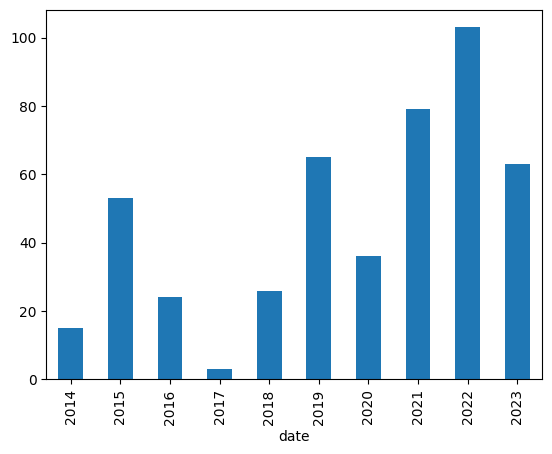

In [12]:
func_df["date"] = pd.to_datetime(func_df["date"], unit="s")
func_df["date"].dt.year.value_counts().sort_index().plot(kind="bar")

In [9]:
# inspection for length
# show the ids for the longest image_codes
func_df.sort_values("image_code", key=lambda x: x.str.len(), ascending=False).head(10)["id"]
# Stack v2 filters: 100k rows, https://github.com/go-enry/go-enry (is_generated), less than 25% of alphabetic characters, encoded, 
# https://www.shadertoy.com/view/NstGDM (contains a neural network in the code, don't want that)


# func_df["comment"].apply(len).describe(percentiles=[.5, .75, .9, .95, .99])

2473    NstGDM
231     4d33z4
232     4d33z4
239     4d33z4
240     4d33z4
242     4d33z4
243     4d33z4
246     4d33z4
247     4d33z4
283     Xs3GRM
Name: id, dtype: object

In [86]:
combined_df.sort_values(by="date", ascending=True).drop_duplicates("author")["date"].dt.year.value_counts().sort_index()#.plot.bar(alpha=0.3, color="red")
# combined_df.sort_values(by="date", ascending=False).drop_duplicates("author")["date"].dt.year.value_counts().sort_index()#.plot.bar(alpha=0.3, color="blue")

date
2014     2
2015     6
2016     4
2017     6
2018     4
2019    16
2020    16
2021    16
2022    21
2023    25
Name: count, dtype: int64

In [10]:
# Shaders per year, in the combined verison... will get published to API instead.
# all_combined_df["date"] = pd.to_datetime(all_combined_df["date"].astype(int), unit="s") # this should only be run once.
all_combined_df["date"].dt.year.value_counts().sort_index()#.plot(kind="bar", title="shaders per year")

AttributeError: Can only use .dt accessor with datetimelike values

In [ ]:
all_combined_df["license"].value_counts()/len(all_combined_df)

In [11]:
# check for the percentage of alphabetic characters in the whole code.
api_df[api_df["image_code"].apply(lambda x: sum(c.isalpha() for c in x) / len(x)) < .25][["id"]]#, "comment", "header"]]

,id
2229,NstGDM


In [5]:
# extract the shader_ids that are left in the end to run tests just on them.
# with open("data/ids/v0-3.txt", "w", encoding="utf-8") as f:
    # f.write("\n".join(func_df["id"].unique().tolist()))

In [89]:
print(func_df["id"].nunique()) # our 719 functions are just from 290 programs?
func_df["header"].str.split(" ").apply(lambda x: x[0]).value_counts()
# func_df["header"].str.startswith("void").sum()

204


header
float              236
vec3               109
vec2                57
vec4                37
void                 7
mat3                 5
bool                 4
bound3               3
v33                  3
tilingVal3D          2
cast_ray_result      1
hexParams            1
ivec2                1
ivec3                1
Name: count, dtype: int64

In [90]:
# some temporary columns
all_funcs["function"] = all_funcs["header"] + all_funcs["body"]
func_df["function"] = func_df["header"] + func_df["body"]
func_df["function_frequency"] = all_funcs["function"].value_counts()[func_df["function"]].values
func_df["header_frequency"] = all_funcs["header"].value_counts()[func_df["header"]].values
func_df

,id,author,date,image_code,license,func_bytes,functions,comment,header,docstring,body,model_inp,needed,function,function_frequency
15,lsfXWH,iq,2014-05-15 00:14:43,// The MIT License\n// Copyright © 2014 Inigo ...,mit,"[3256, 3289, 3316, 3316, 3347]","[[1978, 2039, 2083, 2083, 3254], [3256, 3289, ...",// unrolled version of the above\n,float SH_0_0( in vec3 s ) {,,vec3 n = s.zxy; return k01; },// unrolled version of the above\nfloat SH_0_0...,True,float SH_0_0( in vec3 s ) { vec3 n = s.zxy; re...,3
35,4ssSRl,iq,2014-07-18 08:21:44,// The MIT License\n// Copyright © 2014 Inigo ...,mit,"[0, 1196, 1243, 1243, 1363]","[[0, 1196, 1243, 1243, 1363], [1365, 1365, 142...",// The MIT License\n// Copyright © 2014 Inigo ...,"float line( in vec2 a, in vec2 b, in vec2 p )\n{",,\n\tvec2 pa = p - a;\n\tvec2 ba = b - a;\n\tfl...,// The MIT License\n// Copyright © 2014 Inigo ...,True,"float line( in vec2 a, in vec2 b, in vec2 p )\...",3
37,4djXzz,otaviogood,2014-08-21 06:53:07,/*--------------------------------------------...,cc0-1.0,"[562, 589, 612, 612, 689]","[[562, 589, 612, 612, 689], [690, 690, 713, 71...",// various noise functions\n,float Hash2d(vec2 uv)\n{,,\n float f = uv.x + uv.y * 47.0;\n retur...,// various noise functions\nfloat Hash2d(vec2 ...,True,float Hash2d(vec2 uv)\n{\n float f = uv.x +...,4
48,4dBXz3,iq,2014-10-24 08:55:07,// The MIT License\n// Copyright © 2014 Inigo ...,mit,"[1272, 1348, 1388, 1388, 1443]","[[1272, 1348, 1388, 1388, 1443], [1445, 1524, ...",// Flip v if in the negative half plane define...,"vec2 flipIfNeg( in vec2 v, in vec2 r )\n{",,"\n float k = dot(v,r);\n return (k>0.0) ...",// Flip v if in the negative half plane define...,True,"vec2 flipIfNeg( in vec2 v, in vec2 r )\n{\n ...",1
49,4dBXz3,iq,2014-10-24 08:55:07,// The MIT License\n// Copyright © 2014 Inigo ...,mit,"[1445, 1524, 1564, 1564, 1626]","[[1272, 1348, 1388, 1388, 1443], [1445, 1524, ...",// Reflect v if in the negative half plane def...,"vec2 reflIfNeg( in vec2 v, in vec2 r )\n{",,"\n float k = dot(v,r);\n return (k>0.0) ...",// Reflect v if in the negative half plane def...,True,"vec2 reflIfNeg( in vec2 v, in vec2 r )\n{\n ...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2981,clKfWm,afl_ext,2023-12-09 21:45:07,// afl_ext 2017-2023\n// MIT License\n\n// Use...,mit,"[4801, 4870, 4894, 4894, 5105]","[[993, 1070, 1130, 1130, 1523], [1525, 1592, 1...",// Pretty self explanatory FBM with some preci...,float cloudsFBM(vec3 p){,,\n float a = 0.0;\n float w = 0.5;\n ...,// Pretty self explanatory FBM with some preci...,True,float cloudsFBM(vec3 p){\n float a = 0.0;\n...,1
2983,clKfWm,afl_ext,2023-12-09 21:45:07,// afl_ext 2017-2023\n// MIT License\n\n// Use...,mit,"[5221, 5393, 5424, 5424, 6194]","[[993, 1070, 1130, 1130, 1523], [1525, 1592, 1...",// this function probes the clouds densite at ...,vec2 cloudsDensity3D(vec3 pos){,,\n float h = getHeightOverSurface(pos);\n ...,// this function probes the clouds densite at ...,True,vec2 cloudsDensity3D(vec3 pos){\n float h =...,1
2985,clKfWm,afl_ext,2023-12-09 21:45:07,// afl_ext 2017-2023\n// MIT License\n\n// Use...,mit,"[7849, 8201, 8257, 8257, 8618]","[[993, 1070, 1130, 1130, 1523], [1525, 1592, 1...","// very native rendering for the ground, shado...","vec3 renderGround(vec3 point, float dist, floa...",,\n float shadow = raymarchClouds(\n ...,"// very native rendering for the ground, shado...",True,"vec3 renderGround(vec3 point, float dist, floa...",1
2986,clKfWm,afl_ext,2023-12-09 21:45:07,// afl_ext 2017-2023\n// MIT License\n\n// Use...,mit,"[8625, 8713, 8806, 8806, 9094]","[[993, 1070, 1130, 1130, 1523], [1525, 1592, 1...","// Straightforward, render raymarch, apply fog...","vec3 renderClouds(vec3 pointStart, vec3 pointE...",,\n vec4 clouds = raymarchClouds(\n ...,"// Straightforward, render raymarch, apply fog...",True,"vec3 renderClouds(vec3 pointStart, vec3 pointE...",1


In [92]:
# drop some columns we don't need in the dataset
clean_func_df = func_df.drop(columns=["function", "docstring", "needed"])
clean_func_df

,id,author,date,image_code,license,func_bytes,functions,comment,header,body,model_inp,function_frequency
15,lsfXWH,iq,2014-05-15 00:14:43,// The MIT License\n// Copyright © 2014 Inigo ...,mit,"[3256, 3289, 3316, 3316, 3347]","[[1978, 2039, 2083, 2083, 3254], [3256, 3289, ...",// unrolled version of the above\n,float SH_0_0( in vec3 s ) {,vec3 n = s.zxy; return k01; },// unrolled version of the above\nfloat SH_0_0...,3
35,4ssSRl,iq,2014-07-18 08:21:44,// The MIT License\n// Copyright © 2014 Inigo ...,mit,"[0, 1196, 1243, 1243, 1363]","[[0, 1196, 1243, 1243, 1363], [1365, 1365, 142...",// The MIT License\n// Copyright © 2014 Inigo ...,"float line( in vec2 a, in vec2 b, in vec2 p )\n{",\n\tvec2 pa = p - a;\n\tvec2 ba = b - a;\n\tfl...,// The MIT License\n// Copyright © 2014 Inigo ...,3
37,4djXzz,otaviogood,2014-08-21 06:53:07,/*--------------------------------------------...,cc0-1.0,"[562, 589, 612, 612, 689]","[[562, 589, 612, 612, 689], [690, 690, 713, 71...",// various noise functions\n,float Hash2d(vec2 uv)\n{,\n float f = uv.x + uv.y * 47.0;\n retur...,// various noise functions\nfloat Hash2d(vec2 ...,4
48,4dBXz3,iq,2014-10-24 08:55:07,// The MIT License\n// Copyright © 2014 Inigo ...,mit,"[1272, 1348, 1388, 1388, 1443]","[[1272, 1348, 1388, 1388, 1443], [1445, 1524, ...",// Flip v if in the negative half plane define...,"vec2 flipIfNeg( in vec2 v, in vec2 r )\n{","\n float k = dot(v,r);\n return (k>0.0) ...",// Flip v if in the negative half plane define...,1
49,4dBXz3,iq,2014-10-24 08:55:07,// The MIT License\n// Copyright © 2014 Inigo ...,mit,"[1445, 1524, 1564, 1564, 1626]","[[1272, 1348, 1388, 1388, 1443], [1445, 1524, ...",// Reflect v if in the negative half plane def...,"vec2 reflIfNeg( in vec2 v, in vec2 r )\n{","\n float k = dot(v,r);\n return (k>0.0) ...",// Reflect v if in the negative half plane def...,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2981,clKfWm,afl_ext,2023-12-09 21:45:07,// afl_ext 2017-2023\n// MIT License\n\n// Use...,mit,"[4801, 4870, 4894, 4894, 5105]","[[993, 1070, 1130, 1130, 1523], [1525, 1592, 1...",// Pretty self explanatory FBM with some preci...,float cloudsFBM(vec3 p){,\n float a = 0.0;\n float w = 0.5;\n ...,// Pretty self explanatory FBM with some preci...,1
2983,clKfWm,afl_ext,2023-12-09 21:45:07,// afl_ext 2017-2023\n// MIT License\n\n// Use...,mit,"[5221, 5393, 5424, 5424, 6194]","[[993, 1070, 1130, 1130, 1523], [1525, 1592, 1...",// this function probes the clouds densite at ...,vec2 cloudsDensity3D(vec3 pos){,\n float h = getHeightOverSurface(pos);\n ...,// this function probes the clouds densite at ...,1
2985,clKfWm,afl_ext,2023-12-09 21:45:07,// afl_ext 2017-2023\n// MIT License\n\n// Use...,mit,"[7849, 8201, 8257, 8257, 8618]","[[993, 1070, 1130, 1130, 1523], [1525, 1592, 1...","// very native rendering for the ground, shado...","vec3 renderGround(vec3 point, float dist, floa...",\n float shadow = raymarchClouds(\n ...,"// very native rendering for the ground, shado...",1
2986,clKfWm,afl_ext,2023-12-09 21:45:07,// afl_ext 2017-2023\n// MIT License\n\n// Use...,mit,"[8625, 8713, 8806, 8806, 9094]","[[993, 1070, 1130, 1130, 1523], [1525, 1592, 1...","// Straightforward, render raymarch, apply fog...","vec3 renderClouds(vec3 pointStart, vec3 pointE...",\n vec4 clouds = raymarchClouds(\n ...,"// Straightforward, render raymarch, apply fog...",1


In [ ]:
# maybe something to show which kind of shaders are easy/simple?
# the common tags in our dataset are 2d (73 out of 394), sdf (61), 3d (47), distance (39) etc?
# according to the full dataset, our filters have blindspots in "fractal", "raymarching", "noise", "procedural"
from collections import Counter
print("all:", end="")
all_tags = []
for t in all_combined_df["tags"]:
    all_tags.extend(t)
print(len(all_tags))
tag_counts = Counter(all_tags)
print(tag_counts.most_common(10))
print("eval:", end="")
eval_ids = func_df["id"].tolist()
all_tags = []
for t in all_combined_df[all_combined_df["id"].isin(eval_ids)]["tags"]:
    all_tags.extend(t)
print(len(all_tags))
tag_counts = Counter(all_tags)
print(tag_counts.most_common(10))

In [95]:
# publishing the v0.3 version with context="comment" and all the filters.
from datasets import Dataset
func_ds = Dataset.from_pandas(clean_func_df)
func_ds = func_ds.remove_columns(['__index_level_0__'])
func_ds
# func_ds.push_to_hub("Vipitis/Shadereval-experiments-dev", commit_message="initial v0.4 with 467", private=False, split="test") # don't easily uncomment again...

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/Vipitis/Shadereval-experiments-dev/commit/6bb952fd56153f6c57c19ea0e2c4acd46421b370', commit_message='initial v0.4 with 467', commit_description='', oid='6bb952fd56153f6c57c19ea0e2c4acd46421b370', pr_url=None, pr_revision=None, pr_num=None)

In [94]:
print(func_df["author"].nunique())
func_df["license"].value_counts()

55


license
mit           299
cc0-1.0       145
cc-by-4.0      15
libpng          5
cc-by-3.0       1
isc             1
apache-2.0      1
Name: count, dtype: int64

In [ ]:
plot_per_month("license", stretched=False, data=combined_df, legend=True)

<Axes: title={'center': 'id'}, xlabel='date'>

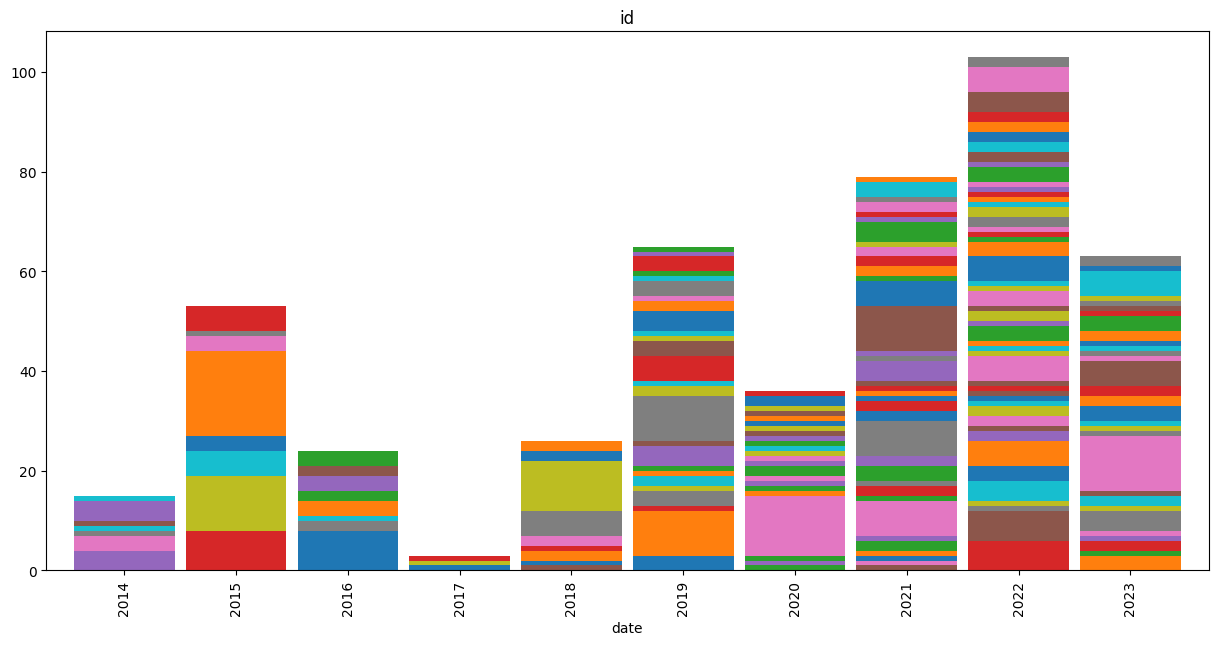

In [88]:
# this is skewed due to duplicates -.-
plot_per_year("id", stretched=False, data=func_df, legend=False)

<Axes: title={'center': 'id'}, xlabel='date'>

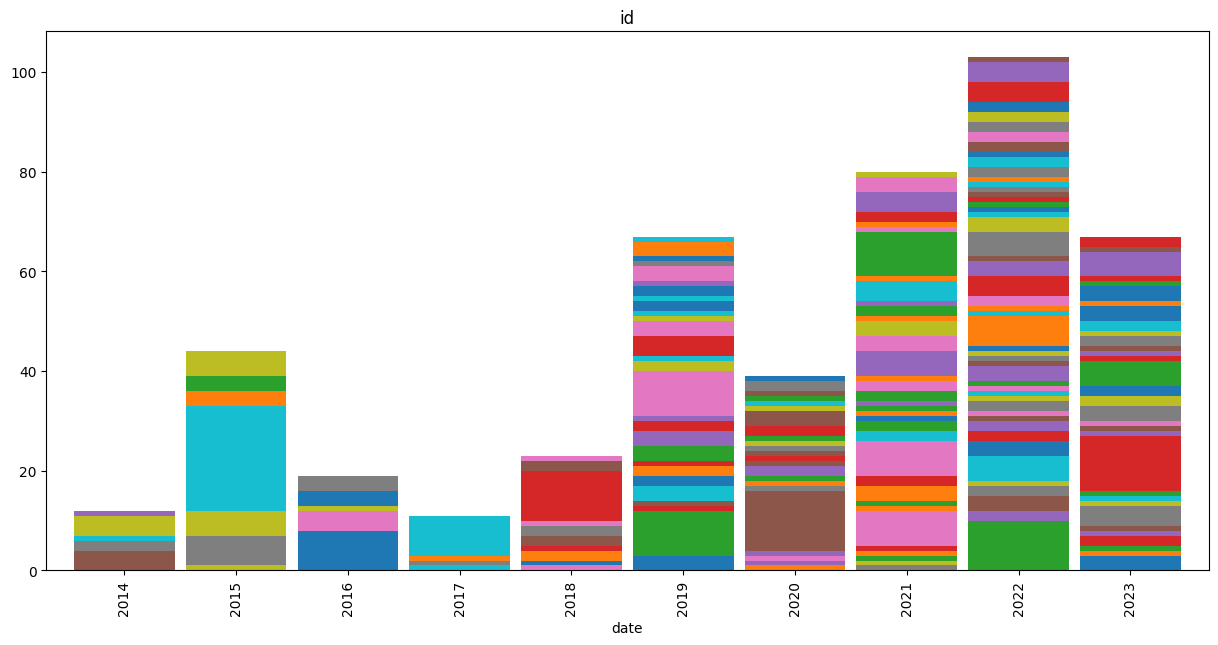

In [22]:
# this is recent perfer
plot_per_year("id", stretched=False, data=func_df, legend=False)

In [1]:
from datasets import load_dataset, disable_caching
# disable_caching()
ref_ds = load_dataset("Vipitis/Shadereval-experiments-dev", revision="main", split="test")# , download_mode="force_redownload") #might be revision="0.3" eventually.
ref_ds

Dataset({
    features: ['id', 'author', 'date', 'image_code', 'license', 'func_bytes', 'functions', 'comment', 'header', 'body', 'model_inp', 'function_frequency'],
    num_rows: 467
})

In [ ]:
# some functions appear multiple times but at most thirce, and a few twice...
# comments appear up to 15 times which is odd, but all this SDF references I think.
import pandas as pd
ref_df = ref_ds.to_pandas()
ref_df["header"].value_counts().head(20)

In [ ]:
for row in ref_ds:
    print(row)
    break

In [ ]:
# all_funcs["id"].nunique() # 27428 shaders/programs
# all_funcs["header"].nunique() # 78256 unique headers
# all_funcs["body"].nunique() # 130948 unique bodies
all_funcs["function"] = all_funcs["header"] + all_funcs["body"]
all_funcs["function"].nunique() # 137308 unique functions

all_funcs["function"].value_counts().head(20)

In [ ]:
# function/header frequency in the eval set.
all_funcs["header"].value_counts()[func_df["header"]].sort_values(ascending=False).plot(ylim=(0,200), xticks=[]) 
all_funcs["body"].value_counts()[func_df["body"]].sort_values(ascending=False).plot(xticks=[])
all_funcs["function"].value_counts()[func_df["function"]].sort_values(ascending=False).plot(xticks=[])

In [ ]:
# unique timestamps per year

df_dates = pd.DataFrame(func_df["date"].unique(), columns=["date"])
df_dates["date"].dt.year.value_counts().sort_index()#.plot(kind="bar")

In [17]:
# collect all panics
import tempfile
import subprocess
import os
from tqdm.auto import tqdm

_file_template = """
from wgpu_shadertoy import Shadertoy

shader_code = '''{}'''

shader = Shadertoy(shader_code, shader_type="glsl", offscreen=True)

if __name__ == "__main__":
    shader.show()
    shader.snapshot(123.45)
"""

def _run_shader_in_subprocess(shader_code:str, timeout:float=10) -> str:
    """
    writes the shadercode into a temporary file, and tries to run the shader with a snapshot. This will catch any kind of errors or panics. Even the really bad ones.
    a timeout can be specified. But the enumerate adapter is rather slow, so it can take over 5 seconds just to do that on a slow computer. Therefore a timeout in the range of 10 seconds is needed to avoid false detections.
    returns either "ok", "timeout" or "error"
    #TODO: not tested on unix systems, might required a change in the python command to call.
    """
    status = "ok" # default case
    with tempfile.NamedTemporaryFile(mode="w", suffix=".py", delete=False, encoding="utf-8") as f:
        f.write(_file_template.format(shader_code))
        f.flush()
        try:
            p = subprocess.run(["python", f.name], capture_output=True, timeout=timeout) # this might not work as expect on Linux ...
            
        except Exception as e:
            if isinstance(e, subprocess.TimeoutExpired):
                status = "timeout"
            else:
                status = "other validation error"
    
    # cleanup temp file, delete_on_close was only added in Python 3.12?
    os.remove(f.name)
        
    if status == "ok":
        if p.returncode != 0:
            msg = p.stderr.decode("utf-8")
            if "panic" in msg:
                status = "panic"
                print(msg)
            else:
                status = "error"
    return status

# load the full thing?
api_df = load_data("./data/annotated/api")

In [ ]:
# 7 in the first 1578
for row in tqdm(api_df.itertuples()):
    res = _run_shader_in_subprocess(row.image_code)
    if res == "panic":
        print("\n from:", row.id)
        print(res)
        # break

In [2]:
new_code = """
void mainImage( out vec4 fragColor, in vec2 fragCoord )
{
    // Normalized pixel coordinates (from 0 to 1)
    vec2 uv = fragCoord/iResolution.xy;

    // Time varying pixel color
    vec3 col = 0.5 + 0.5*cos(iTime+uv.xyx+vec3(0,2,4));

    // Output to screen
    fragColor = vec4(col,1.0);
}
"""

new_codes = [new_code] * len(ref_ds)

print(len(new_codes))

467


In [6]:
# testing against the new code to make sure it works. expected 1.0 variation and also might take 30 minutes...
import evaluate

shadermatch = evaluate.load("Vipitis/shadermatch") # public

# res = shadermatch.compute(references=ref_ds["image_code"], predictions=new_codes)

In [2]:
import datasets

loaded_ds = datasets.load_from_disk("./data/prepared/")
loaded_df = loaded_ds.to_pandas()
# loaded_df.drop(columns=["function", "docstring", "needed"], inplace=True)

ref_ds = datasets.load_dataset("Vipitis/Shadereval-experiments-dev", revision="main", split="test")
ref_df = ref_ds.to_pandas()

In [3]:
# order is still the same
loaded_ds["model_inp"] == ref_ds["model_inp"]

True

In [4]:
loaded_df.sort_values("header_frequency", ascending=False).head(10)

,id,author,date,image_code,license,func_bytes,functions,comment,header,body,model_inp,function_frequency,header_frequency
68,MsyXDV,SparkX120,2016-06-23 04:30:06,/**\n * Adapted from my Mandelbrot-JS Project\...,mit,"[0, 1289, 1346, 1346, 2956]","[[0, 1289, 1346, 1346, 2956]]",/**\n * Adapted from my Mandelbrot-JS Project\...,"void mainImage( out vec4 fragColor, in vec2 fr...",\n const float iterations = 512.;\n c...,/**\n * Adapted from my Mandelbrot-JS Project\...,1,16281
315,NdfBDl,jackakers13,2022-02-22 10:11:58,"// Created by Jack Akers on February 22, 2022....",cc0-1.0,"[0, 140, 195, 214, 746]","[[0, 140, 195, 214, 746]]","// Created by Jack Akers on February 22, 2022....","void mainImage(out vec4 fragColor, in vec2 fra...","\n vec2 center = vec2(iResolution.x/2.0, iR...","// Created by Jack Akers on February 22, 2022....",1,901
263,NlXXzs,iq,2021-07-14 17:22:14,// The MIT License\n// Copyright © 2021 Inigo ...,mit,"[2362, 2433, 2464, 2464, 2555]","[[1209, 1475, 1517, 1517, 1710], [1712, 1742, ...",// https://iquilezles.org/www/articles/distfun...,"float sdBox( vec3 p, vec3 b )\n{",\n vec3 d = abs(p) - b;\n return min(max...,// https://iquilezles.org/www/articles/distfun...,61,579
181,Ws3XWl,iq,2019-11-13 23:45:13,// The MIT License\n// Copyright © 2019 Inigo ...,mit,"[1856, 1926, 1957, 1957, 2048]","[[1655, 1729, 1751, 1751, 1854], [1856, 1926, ...",// http://iquilezles.org/www/articles/distfunc...,"float sdBox( vec3 p, vec3 b )\n{",\n vec3 d = abs(p) - b;\n return min(max...,// http://iquilezles.org/www/articles/distfunc...,61,579
16,XljGDz,otaviogood,2015-04-07 03:58:40,/*--------------------------------------------...,cc0-1.0,"[2998, 3034, 3075, 3075, 3168]","[[856, 856, 879, 879, 908], [909, 909, 932, 93...",// polynomial smooth min (k = 0.1);\n,"float smin( float a, float b, float k )\n{","\n float h = clamp( 0.5+0.5*(b-a)/k, 0.0, 1...",// polynomial smooth min (k = 0.1);\nfloat smi...,176,382
116,lt3BW2,iq,2018-11-01 04:49:23,// The MIT License\n// Copyright © 2018 Inigo ...,mit,"[4550, 4614, 4646, 4646, 4880]","[[1702, 1702, 1739, 1739, 1764], [1766, 1766, ...",// http://iquilezles.org/www/articles/normalsS...,vec3 calcNormal( in vec3 pos )\n{,\n const float ep = 0.0001;\n vec2 e = v...,// http://iquilezles.org/www/articles/normalsS...,6,360
310,stKSzc,iq,2022-01-03 03:36:24,// The MIT License\n// Copyright © 2021 Inigo ...,mit,"[2294, 2340, 2372, 2372, 2611]","[[1588, 1643, 1699, 1699, 1990], [1992, 1992, ...",// https://iquilezles.org/articles/normalsSDF\n,vec3 calcNormal( in vec3 pos )\n{,"\n vec2 e = vec2(1.0,-1.0)*0.5773;\n con...",// https://iquilezles.org/articles/normalsSDF\...,23,360
455,dtGBRG,Dain,2023-12-11 01:18:25,// https://www.shadertoy.com/view/dtGBDz ortho...,mit,"[6779, 6843, 6885, 6885, 7175]","[[2307, 2307, 2430, 2430, 3560], [3562, 3562, ...",// https://www.shadertoy.com/view/Xds3zN rayma...,"float calcAO( in vec3 pos, in vec3 nor )\n{",\n float occ = 0.0;\n float sca = 1.0;\n...,// https://www.shadertoy.com/view/Xds3zN rayma...,1,259
256,7tj3DG,mrange,2021-06-25 18:20:12,// License CC0: Random friday fractal\n// Resu...,cc0-1.0,"[584, 637, 659, 659, 828]","[[458, 458, 486, 506, 582], [584, 637, 659, 65...",// From: https://stackoverflow.com/a/17897228/...,vec3 hsv2rgb(vec3 c) {,"\n const vec4 K = vec4(1.0, 2.0 / 3.0, 1.0 / ...",// From: https://stackoverflow.com/a/17897228/...,22,237
239,NdS3WW,mrange,2021-04-02 13:52:21,"// License CC0: The monolith, 1x4x9\n\n#define...",cc0-1.0,"[994, 1073, 1095, 1095, 1264]","[[715, 715, 743, 763, 839], [841, 865, 904, 90...",// https://stackoverflow.com/questions/1509590...,vec3 hsv2rgb(vec3 c) {,"\n const vec4 K = vec4(1.0, 2.0 / 3.0, 1.0 / ...",// https://stackoverflow.com/questions/1509590...,22,237


<Axes: >

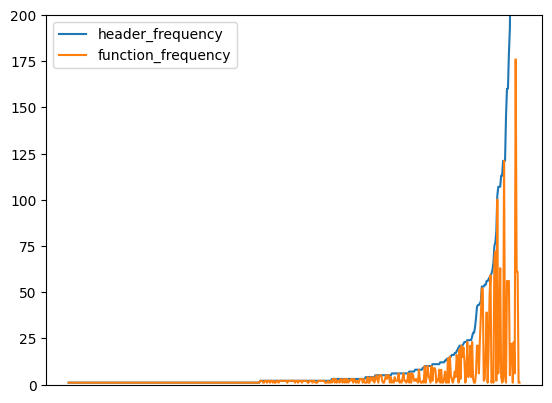

In [5]:
loaded_df.sort_values(by="header_frequency").reset_index(drop=True)[["header_frequency", "function_frequency"]].plot(ylim=(0,200), xticks=[])

<Axes: >

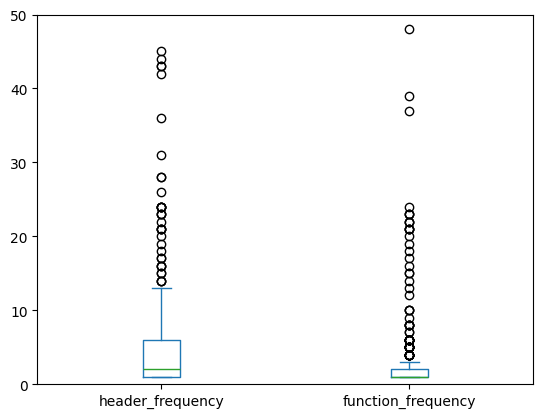

In [6]:
loaded_df[["header_frequency", "function_frequency"]].plot.box(ylim=(0,50))

In [7]:
loaded_df[loaded_df["header"].duplicated()].sort_values("header").head(10)

,id,author,date,image_code,license,func_bytes,functions,comment,header,body,model_inp,function_frequency,header_frequency
308,7tVXRt,iq,2022-01-03 19:29:53,// The MIT License\n// Copyright © 2022 Inigo ...,mit,"[1914, 1959, 2046, 2046, 2304]","[[1396, 1470, 1532, 1532, 1716], [1718, 1718, ...",// https://iquilezles.org/articles/rmshadows\n,"float calcSoftshadow( in vec3 ro, in vec3 rd, ...",\n\tfloat res = 1.0;\n float t = tmin;\n ...,// https://iquilezles.org/articles/rmshadows\n...,1,10
171,WsV3zz,iq,2019-10-01 00:21:04,// The MIT License\n// Copyright © 2019 Inigo ...,mit,"[2155, 2173, 2201, 2201, 2359]","[[1950, 1989, 2011, 2011, 2153], [2155, 2173, ...",// gradient noise\n,float gnoise( in float p )\n{,\n int i = int(floor(p));\n float f = ...,// gradient noise\nfloat gnoise( in float p )\n{,1,2
378,fddBD2,iq,2022-07-07 22:16:10,// The MIT License\n// Copyright © 2022 Inigo ...,mit,"[4334, 4392, 4457, 4475, 4820]","[[2473, 2473, 2893, 2893, 3577], [3579, 3579, ...",// https://iquilezles.org/articles/filterablep...,"float gridTextureGradBox( in vec2 p, in vec2 d...","\n vec2 w = max(abs(ddx), abs(ddy)) + 0.01;...",// https://iquilezles.org/articles/filterablep...,2,6
390,NtKBWh,mrange,2022-09-29 05:45:01,// License CC0: Dark chocolate FBM\n// Workin...,cc0-1.0,"[1768, 1868, 1907, 1907, 1992]","[[592, 592, 614, 614, 760], [1055, 1155, 1174,...","// License: MIT, author: Inigo Quilez, found: ...","float pmin(float a, float b, float k) {","\n float h = clamp(0.5+0.5*(b-a)/k, 0.0, 1.0)...","// License: MIT, author: Inigo Quilez, found: ...",63,107
319,7sXfDH,mrange,2022-02-13 22:28:54,// License CC0: Follow the light\n// Result af...,cc0-1.0,"[1522, 1605, 1644, 1644, 1733]","[[968, 1068, 1089, 1089, 1162], [1163, 1263, 1...","// License: MIT, author: Inigo Quilez, found: ...","float pmin(float a, float b, float k) {","\n float h = clamp( 0.5+0.5*(b-a)/k, 0.0, 1.0...","// License: MIT, author: Inigo Quilez, found: ...",22,107
259,slj3Dd,iq,2021-06-30 05:08:46,// The MIT License\n// Copyright © 2021 Inigo ...,mit,"[1261, 1351, 1415, 1499, 2515]","[[1261, 1351, 1415, 1499, 2515], [2517, 2517, ...",// The arrow goes from a to b. It's thickness ...,"float sdArrow( in vec2 p, vec2 a, vec2 b, floa...",\n const float k = 3.0; // arrow head rat...,// The arrow goes from a to b. It's thickness ...,1,2
263,NlXXzs,iq,2021-07-14 17:22:14,// The MIT License\n// Copyright © 2021 Inigo ...,mit,"[2362, 2433, 2464, 2464, 2555]","[[1209, 1475, 1517, 1517, 1710], [1712, 1742, ...",// https://iquilezles.org/www/articles/distfun...,"float sdBox( vec3 p, vec3 b )\n{",\n vec3 d = abs(p) - b;\n return min(max...,// https://iquilezles.org/www/articles/distfun...,61,579
69,MsVXDt,otaviogood,2016-07-20 06:51:21,/*--------------------------------------------...,cc0-1.0,"[2400, 2602, 2636, 2636, 2747]","[[1174, 1203, 1222, 1222, 1267], [1268, 1268, ...",// ---- shapes defined by distance fields ----...,"float sdBox(vec3 p, vec3 radius)\n{",\n vec3 dist = abs(p) - radius;\n return min...,// ---- shapes defined by distance fields ----...,10,10
408,ddd3zs,iq,2023-03-02 04:52:06,// The MIT License\n// Copyright © 2023 Inigo ...,mit,"[2980, 3029, 3081, 3081, 3195]","[[1213, 1264, 1328, 1451, 2914], [2980, 3029, ...",// https://iquilezles.org/articles/distfunctio...,"float sdCapsule( vec3 p, vec3 a, vec3 b, float...","\n\tvec3 pa = p-a, ba = b-a;\n\tfloat h = clam...",// https://iquilezles.org/articles/distfunctio...,56,160
300,sl3XRn,iq,2021-12-04 00:18:43,// The MIT License\n// Copyright © 2021 Inigo ...,mit,"[2083, 2158, 2208, 2208, 2236]","[[1114, 1114, 1149, 1149, 1177], [1179, 1179, ...",// https://iquilezles.org/www/articles/distfun...,"float sdDisk( in vec2 p, in vec2 c, in float r...",\n return length(p-c)-r;\n},// https://iquilezles.org/www/articles/distfun...,2,2


In [8]:
print(loaded_df["model_inp"][320])
print(loaded_df["model_inp"][386])

// License: MIT, author: Inigo Quilez, found: https://iquilezles.org/articles/spherefunctions
float sphered(vec3 ro, vec3 rd, vec4 sph, float dbuffer) {
// License: MIT, author: Inigo Quilez, found: https://www.iquilezles.org/www/articles/spherefunctions/spherefunctions.htm
float sphered(vec3 ro, vec3 rd, vec4 sph, float dbuffer) {


In [15]:
import datasets
loaded_df
func_ds = datasets.Dataset.from_pandas(loaded_df)
# func_ds = func_ds.remove_columns(['__index_level_0__'])
func_ds
# func_ds.push_to_hub("Vipitis/Shadereval-experiments-dev", commit_message="adding header_frequency", private=False, split="test") # don't easily uncomment again...

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/Vipitis/Shadereval-experiments-dev/commit/274eb4d3017d59da2a1f48bc7194be1545de919f', commit_message='adding header_frequency', commit_description='', oid='274eb4d3017d59da2a1f48bc7194be1545de919f', pr_url=None, pr_revision=None, pr_num=None)

In [1]:
# make a plot of shaders per year. compare s20k, api and plot the overlap too!
import os
import jsonlines
import pandas as pd
import matplotlib.pyplot as plt

def load_data(data_dir: os.PathLike) -> pd.DataFrame:
    lines = []
    for file in os.listdir(data_dir):
        if file.endswith(".jsonl"):
            with jsonlines.open(os.path.join(data_dir, file)) as reader:
                for obj in reader:
                    lines.append(obj)

    out_df = pd.DataFrame(lines)
    out_df["date"] = pd.to_datetime(out_df["date"].astype(int), unit="s")
    return out_df

all_shaders20k = load_data("./data/annotated")
# all_api = load_data("./data/annotated/api")
print(len(all_shaders20k))
# print(len(all_api))

s20k_ids = {k:v for k,v in all_shaders20k.groupby(all_shaders20k["date"].dt.year)["id"].unique().items()}
print(len(s20k_ids[2021]))


19622
3858


In [2]:
ids_path = "./data/ids/"
api_ids = {}
for file in os.listdir(ids_path):
    if file.endswith(".txt") and file.startswith("api_"):
        year = int(file.split("_")[1].removesuffix(".txt"))
        with open(os.path.join(ids_path, file), "r", encoding="utf-8") as f:
            api_ids[year] = list(f.read().splitlines())

len(api_ids[2021])

4725

In [3]:
overlap = {k: len(set(v).intersection(api_ids[k])) for k,v in s20k_ids.items()}
overlap

{2014: 156,
 2015: 570,
 2016: 695,
 2017: 851,
 2018: 818,
 2019: 1179,
 2020: 1456,
 2021: 1569}

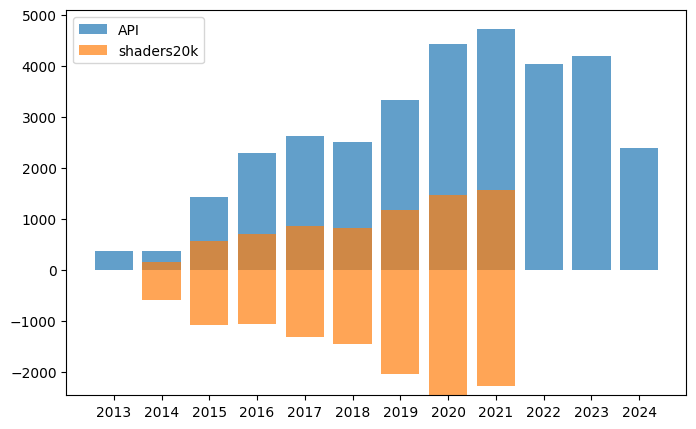

In [5]:
plt.figure(figsize=(8,5))
plt.bar(api_ids.keys(), [len(api_ids[k]) for k in api_ids.keys()], label="API", alpha=0.7)
plt.bar(s20k_ids.keys(), [len(s20k_ids[k]) for k in s20k_ids.keys()], label="shaders20k", alpha=0.7, bottom=[-len(s20k_ids[k])+overlap[k] for k in s20k_ids.keys()])
plt.legend()
plt.xticks(list(api_ids.keys()))
# plt.yticks(list(range(-3000, 5000, 1000)))
plt.savefig("../Thesis/report/texs/charts/shaders_per_year.png")
plt.show()